# Task 3: Correlation Between News Sentiment and Stock Movement

This notebook aims to analyze the correlation between news sentiment and stock market movement.  
We will:

- Import news and stock datasets
- Apply sentiment analysis on headlines
- Compute daily stock returns
- Merge data on date
- Analyze correlation strength


In this section, we imported necessary libraries like pandas for data manipulation, matplotlib and seaborn for visualization, and TextBlob for sentiment analysis of news headlines.

In [9]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns


## Load News and Stock Data

- We used modular functions defined in news_utils.py and stock_utils.py to load both news and stock data. This promotes code reusability and cleanliness.

- load_news_data() imports news articles with date, headline, and publisher.

- load_and_prepare_data() imports OHLCV stock data and converts it into a clean format.

In [10]:
import sys, os
sys.path.insert(0, os.path.abspath('../..'))

from src.descriptive_stats import load_news_data
from src.ta_analysis import load_and_prepare_data, compute_indicators

# Load datasets

news_df = load_news_data("../../data/raw_analyst_ratings.csv")
stock_df = load_and_prepare_data("../../data/yfinance_data/NVDA_historical_data.csv")



## Normalize Dates

In [11]:
from src.date_analysis import (
    parse_dates, daily_article_counts
)
news_df = parse_dates(news_df)

# Rename and convert stock dates for consistency
stock_df['date'] = pd.to_datetime(stock_df['Date'], utc=True)
stock_df.drop(columns='Date', inplace=True)

- The parse_dates() function converted the date column in the news data to a timezone-aware datetime format. We ensured both datasets use a unified datetime column (date) so they can be accurately merged later.

### Sentiment Analysis

In [12]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment scores
news_df["sentiment"] = news_df["headline"].apply(get_sentiment)


- We applied the TextBlob library to calculate sentiment polarity scores for each news headline. These scores range from -1 (negative) to +1 (positive).
- We then added these values as a new column, sentiment, in the news DataFrame.

### Aggregate Daily Sentiment

In [13]:
# Average sentiment per day
daily_sentiment = news_df.resample("D").mean(numeric_only=True)[["sentiment"]].dropna().reset_index()


- News headlines were grouped by date and averaged to calculate a daily sentiment score, which reflects the general tone of news on each day.

### Stock Daily Returns


In [14]:
stock_df.sort_values("date", inplace=True)
stock_df["daily_return"] = stock_df["Close"].pct_change()
stock_df.dropna(subset=["daily_return"], inplace=True)


- We calculated the daily percentage return of the stock using its closing price (pct_change()), giving us a sense of how much the stock moved each day.

### Merge News and Stock Data

In [15]:
# Merge on common 'date' column
merged_df = pd.merge(daily_sentiment, stock_df[["date", "daily_return"]], on="date", how="inner")


- The daily sentiment and stock return datasets were merged on the date column. This gave us a single table where each row contains:

    - average sentiment score for that day

    - daily return for that same day

In [16]:
correlation = merged_df["sentiment"].corr(merged_df["daily_return"])
print(f"📌 Pearson Correlation: {correlation:.4f}")


📌 Pearson Correlation: -0.0264


### Correlation Analysis

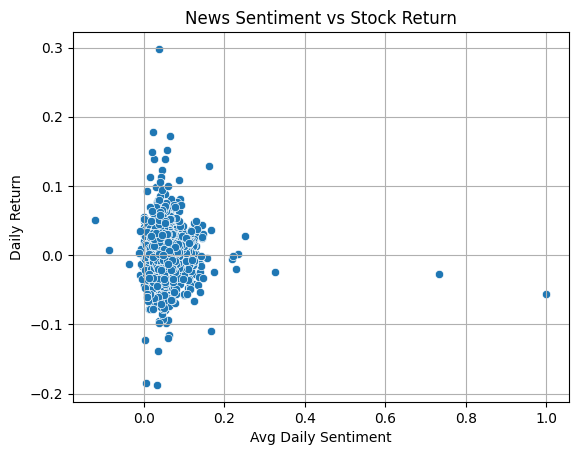

In [17]:
sns.scatterplot(data=merged_df, x="sentiment", y="daily_return")
plt.title("News Sentiment vs Stock Return")
plt.xlabel("Avg Daily Sentiment")
plt.ylabel("Daily Return")
plt.grid(True)
plt.show()


- We calculated the Pearson correlation coefficient between sentiment and daily_return to quantify the relationship between them. A value close to:

    - +1 means strong positive correlation

    - -1 means strong negative correlation

    - 0 means no correlation

### Visualization

- We used seaborn.scatterplot() to plot Average Daily Sentiment (x-axis) against Daily Stock Return (y-axis). Each point represents one day's values.

### Pearson Correlation: -0.0264
A weak negative correlation, but close to zero. It implies a very mild inverse relationship, which is likely noise rather than signal.